Eerst alle codeblokjes achter elkaar runnen. Het belangrijkste is het aan het einde kiezen van de juiste scenario range. Hiervoor moet je ALLEEN het codeblokje met jouw naam runnen!!





In [1]:
# Inladen van alle scenarios en outcomes die we hebben. Deze heb ik opnieuw gerund en gepusht dus chech even in de results folder of deze nieuwe scenario space er in staat!

import pandas as pd

# Define the folder path and file names
folder_name = "results"
date = "2025-06-11"  # Replace with the exact date if needed

# Load the experiments DataFrame
experiments = pd.read_csv(f"{folder_name}/scenario_space_100000_experiments_2025-06-11_21-41.csv")

# Load the outcomes DataFrame
outcomes = pd.read_csv(f"{folder_name}/scenario_space_100000_outcomes_2025-06-11_21-41.csv")

combined_df = pd.concat([experiments, outcomes], axis=1)

print("DataFrames recreated from stored CSV files.")

DataFrames recreated from stored CSV files.


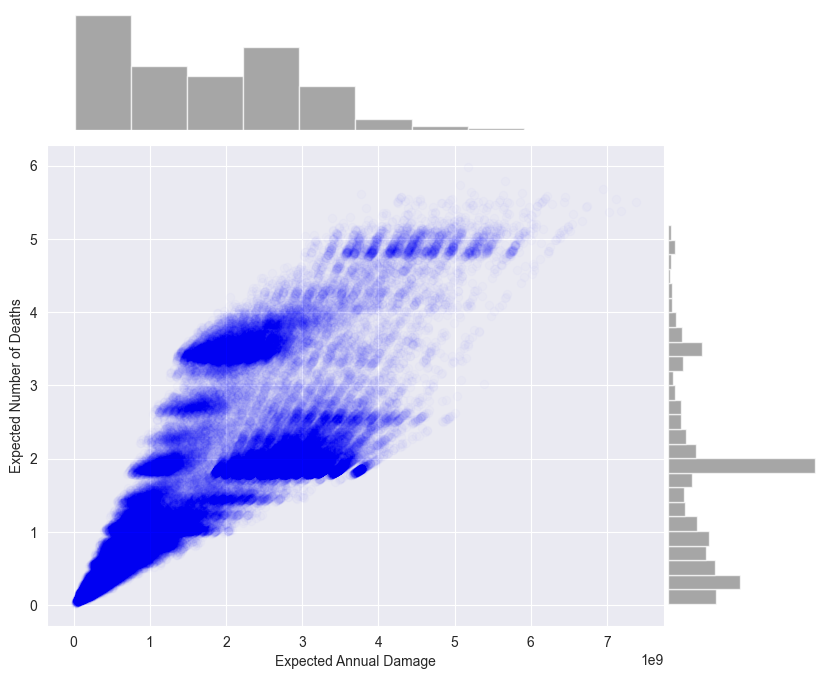

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

df=pd.DataFrame(combined_df)
# Create a figure with a custom layout
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.01)

# Scatter plot
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.scatter(df['Expected Annual Damage'], df['Expected Number of Deaths'], c='blue', alpha=0.01)
ax_scatter.set_xlabel('Expected Annual Damage')
ax_scatter.set_ylabel('Expected Number of Deaths')
ax_scatter.grid(True)

# Histogram for RfR Total Costs
ax_hist_x = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_hist_x.hist(df['Expected Annual Damage'], bins=10, color='gray', alpha=0.7)
ax_hist_x.axis('off')  # Hide axis labels for better aesthetics

# Histogram for Total Deaths
ax_hist_y = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_hist_y.hist(df['Expected Number of Deaths'], bins=30, orientation='horizontal', color='gray', alpha=0.7)
ax_hist_y.axis('off')  # Hide axis labels for better aesthetics

plt.show()

We hebben vanuit de graph en densities bepaalde gebieden bepaald voor scenarios (x, y):

[0,1] [0,1] Favourable scenario => geen of weinig overstromingen (damage, deaths): 2 of these

[6,] [5,] Very unfavourable scenario => veel overstromingen (damage, deaths): 4 of these

[2.5,3.5] [1.8,2.8] Medium favourable scenarios 1 (damage, deaths): 2 of these

[1.5, 2.5] [3, 4] Medium favourable scenarios 2 (damage, deaths): 2 of these

In het volgende stukje worden er random (met seed) scenarios uit gepakt. 2 voor favourable, 4 voor medium, 4 voor unfavourable

In [3]:
import numpy as np
import pandas as pd

# Define the seed for reproducibility
# Seed run 1 was 20
# Seed run 2 was 21
np.random.seed(21)

# Define category-specific bounds
favourable_bounds = [
    [[0, 1], [0, 1]]  # 2 scenarios
]

unfavourable_bounds = [
    [[6, float('inf')], [5, float('inf')]]  # 4 scenarios
]

medium_bounds = [
    [[2.5, 3.5], [1.8, 2.8]],  # 2 scenarios
    [[1.5, 2.5], [3, 4]]       # 2 scenarios
]

# Function to filter and sample based on bounds and desired number of samples
def filter_and_sample(bounds_list, combined_df, n_per_bound):
    results = pd.DataFrame()
    for bound in bounds_list:
        mask = (
            (combined_df['Expected Annual Damage'] >= bound[0][0] * 1e9) &
            (combined_df['Expected Annual Damage'] <= bound[0][1] * 1e9 if not np.isinf(bound[0][1]) else True) &
            (combined_df['Expected Number of Deaths'] >= bound[1][0]) &
            (combined_df['Expected Number of Deaths'] <= bound[1][1] if not np.isinf(bound[1][1]) else True)
        )
        filtered = combined_df[mask].copy()
        if not filtered.empty:
            sampled = filtered.sample(n=min(n_per_bound, len(filtered)), random_state=42)
            results = pd.concat([results, sampled], ignore_index=True)
        else:
            print(f"No outcomes found for bounds {bound}.")
    return results

# Apply to each category
favourable_scenarios_df = filter_and_sample(favourable_bounds, combined_df, 2).iloc[:, :-39]
medium_scenarios_df = filter_and_sample(medium_bounds, combined_df, 2).iloc[:, :-39]
unfavourable_scenarios_df = filter_and_sample(unfavourable_bounds, combined_df, 4).iloc[:, :-39]




This is the run optimization code, the nfe en epsilon here are default values and will be overwritten.
seed of run 1 was 20, seed for run 2 is 21!!

You can plot the convergence graph after each run if you want, just comment out the last section (not essential).

In [4]:
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import EpsNSGAII
import seaborn as sns

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt


def run_optimization(nfe, epsilon, scenario=None):
    ema_logging.log_to_stderr(ema_logging.INFO)
    model, steps = get_model_for_problem_formulation(2)

    #Use default scenario if none is provided
    if scenario is None:
        reference_values = {
            "Bmax": 175,
            "Brate": 1.5,
            "pfail": 0.5,
            "discount rate 0": 3.5,
            "discount rate 1": 3.5,
            "discount rate 2": 3.5,
            "ID flood wave shape": 4,
        }
        scenario_dict = {}
        for key in model.uncertainties:
            name_split = key.name.split("_")
            if len(name_split) == 1:
                scenario_dict[key.name] = reference_values.get(key.name)
            else:
                scenario_dict[key.name] = reference_values.get(name_split[1])
        scenario = Scenario("default", **scenario_dict)

    epsilons = [epsilon] * len(model.outcomes)
    convergence_metrics = [EpsilonProgress()]


    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            algorithm=EpsNSGAII,
            algorithm_kwargs={
                "epsilons": epsilons,
                "problem": scenario,
                "seed": 21, # Seed run 1 = 20, seed run 2 = 21
            },
            convergence=convergence_metrics,
            reference=scenario,
            epsilons=epsilons,
    )

    #Eventueel plot convergence als je dat wilt
    fig, ax1 = plt.subplots(ncols=1)
    ax1.plot(convergence.epsilon_progress)
    ax1.set_xlabel("Number of generations")
    ax1.set_ylabel(r"$\epsilon$ progress")
    sns.despine()
    plt.show()

    return results, convergence

Code voor het opslaan in nieuwe folder, dan hebben we alles goed bij elkaar en staat het niet tussen al onze andere zooi

In [5]:
import os
from datetime import datetime

def save_results_to_csv(result, name):

    current_date = datetime.now().strftime('%Y-%m-%d_%H-%M')

    # Define the folder path
    folder_name = "optimization_150000_seed21_results"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)  # Create the folder if it doesn't exist

    # Save outcomes DataFrame to a CSV file in the folder
    df_result = pd.DataFrame(result)
    df_result.to_csv(os.path.join(folder_name, f'{name}_{current_date}.csv'), index=False)

    print(f"Saved {name}")

# CODE VOOR MEREL

In [ ]:
def run_scenarios_merel(unfavourable_scenarios_df):
    epsilon_value = 1000
    nfe_value = 150000

    num = 0
    for items in unfavourable_scenarios_df.iterrows():
        if num == 2:
            break
        print(f"Running unfavourable scenario {num}...")
        scenario_dict = unfavourable_scenarios_df.iloc[num].to_dict()
        scenario = Scenario(f"unfavourable{num}", **scenario_dict)

        np.random.seed(21)
        result, convergence = run_optimization(epsilon=epsilon_value, nfe=nfe_value, scenario=scenario)

        save_results_to_csv(result, f"unfavourable_outcomes_150000_{num}")
        save_results_to_csv(convergence, f"unfavourable_convergence_150000_{num}")
        num += 1


In [ ]:
run_scenarios_merel(unfavourable_scenarios_df)

# CODE VOOR TWAN

In [6]:
def run_scenarios_twan(unfavourable_scenarios_df):
    epsilon_value = 1000
    nfe_value = 150000

    num = 3
    for items in unfavourable_scenarios_df.iterrows():
        print(f"Running unfavourable scenario {num}...")
        scenario_dict = unfavourable_scenarios_df.iloc[num].to_dict()
        scenario = Scenario(f"unfavourable{num}", **scenario_dict)
        result, convergence = run_optimization(epsilon=epsilon_value, nfe=nfe_value, scenario=scenario)

        np.random.seed(21)
        save_results_to_csv(result, f"unfavourable_outcomes_150000{num}")
        save_results_to_csv(convergence, f"unfavourable_convergence_150000{num}")
        num += 1

In [ ]:
run_scenarios_twan(unfavourable_scenarios_df)

Running unfavourable scenario 3...


[MainProcess/INFO] pool started with 12 workers
 46%|██████████████▎                | 69349/150000 [2:56:58<4:43:56,  4.73it/s]

# CODE VOOR JESSE

In [8]:
def run_scenarios_jesse(medium_scenarios_df):
    epsilon_value = 1000
    nfe_value = 150000

    num = 0
    for items in medium_scenarios_df.iterrows():
        if num == 2:
            break
        print(f"Running medium scenario {num}...")
        scenario_dict = medium_scenarios_df.iloc[num].to_dict()
        scenario = Scenario(f"medium{num}", **scenario_dict)
        result, convergence = run_optimization(epsilon=epsilon_value, nfe=nfe_value, scenario=scenario)

        np.random.seed(21)
        save_results_to_csv(result, f"medium_outcomes_150000{num}")
        save_results_to_csv(convergence, f"medium_convergence_150000{num}")
        num += 1

In [ ]:
run_scenarios_jesse(medium_scenarios_df)

Running medium scenario 0...


[MainProcess/INFO] pool started with 12 workers
  0%|                                   | 500/150000 [00:49<4:15:34,  9.75it/s]

# CODE VOOR PIEN

In [ ]:
def run_scenarios_pien(medium_scenarios_df):
    epsilon_value = 1000
    nfe_value = 150000

    num = 3
    for items in medium_scenarios_df.iterrows():
        print(f"Running medium scenario {num}...")
        scenario_dict = medium_scenarios_df.iloc[num].to_dict()
        scenario = Scenario(f"medium{num}", **scenario_dict)
        result, convergence = run_optimization(epsilon=epsilon_value, nfe=nfe_value, scenario=scenario)

        np.random.seed(21)
        save_results_to_csv(result, f"medium_outcomes_150000{num}")
        save_results_to_csv(convergence, f"medium_convergence_150000{num}")
        num += 1

In [ ]:
run_scenarios_pien(medium_scenarios_df)

# CODE VOOR FAVOURABLE (ZIJN OVER)

In [ ]:
def run_scenarios_favourable(favourable_scenarios_df):
    epsilon_value = 1000
    nfe_value = 150000

    num = 0
    for items in favourable_scenarios_df.iterrows():
        print(f"Running favourable scenario {num}...")
        scenario_dict = favourable_scenarios_df.iloc[num].to_dict()
        scenario = Scenario(f"favourable{num}", **scenario_dict)
        result, convergence = run_optimization(epsilon=epsilon_value, nfe=nfe_value, scenario=scenario)

        np.random.seed(21)
        save_results_to_csv(result, f"favourable_outcomes_150000{num}")
        save_results_to_csv(convergence, f"favourable_convergence_150000{num}")
        num += 1


In [ ]:
run_scenarios_favourable(favourable_scenarios_df)